In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
## Single cell for data loading and pre-processing. Consolidating all relevant steps from the notebook below.

# Step 1 - loading data sets
df_pgen1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_psense1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

# Step 2 - correcting date_time format
df_pgen1['DATE_TIME'] = pd.to_datetime(df_pgen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_psense1['DATE_TIME'] = pd.to_datetime(df_psense1['DATE_TIME'],format = '%Y-%m-%d %H:%M')

# Step 3 - splitting date and time
df_pgen1['DATE'] = df_pgen1['DATE_TIME'].apply(lambda x:x.date())
df_pgen1['TIME'] = df_pgen1['DATE_TIME'].apply(lambda x:x.time())

df_psense1['DATE'] = df_psense1['DATE_TIME'].apply(lambda x:x.date())
df_psense1['TIME'] = df_psense1['DATE_TIME'].apply(lambda x:x.time())

# Step 4 - correcting data_time format for the DATE column
df_pgen1['DATE'] = pd.to_datetime(df_pgen1['DATE'],format = '%Y-%m-%d')
df_psense1['DATE'] = pd.to_datetime(df_psense1['DATE'],format = '%Y-%m-%d')

# Step 5 - splitting hour and minutes
df_pgen1['HOUR'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.hour
df_pgen1['MINUTES'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.minute

df_psense1['HOUR'] = pd.to_datetime(df_psense1['TIME'],format='%H:%M:%S').dt.hour
df_psense1['MINUTES'] = pd.to_datetime(df_psense1['TIME'],format='%H:%M:%S').dt.minute

## Load the data

In [ ]:
df_pgen1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_psense1 = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

In [ ]:
df_pgen1.head()

In [ ]:
df_psense1.head(50)

## Convert the DATE_TIME column to the datetime format

In [ ]:
df_pgen1['DATE_TIME'] = pd.to_datetime(df_pgen1['DATE_TIME'],format = '%d-%m-%Y %H:%M')
df_psense1['DATE_TIME'] = pd.to_datetime(df_psense1['DATE_TIME'],format = '%Y-%m-%d %H:%M')

## Split the Date and Time

In [ ]:
df_pgen1['DATE'] = df_pgen1['DATE_TIME'].apply(lambda x:x.date())
df_pgen1['TIME'] = df_pgen1['DATE_TIME'].apply(lambda x:x.time())

df_psense1['DATE'] = df_psense1['DATE_TIME'].apply(lambda x:x.date())
df_psense1['TIME'] = df_psense1['DATE_TIME'].apply(lambda x:x.time())

## Correct the format of the DATE column

In [ ]:
df_pgen1['DATE'] = pd.to_datetime(df_pgen1['DATE'],format = '%Y-%m-%d')
df_psense1['DATE'] = pd.to_datetime(df_psense1['DATE'],format = '%Y-%m-%d')

## Split the Hour and Minutes for easier analysis

In [ ]:
df_pgen1['HOUR'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.hour
df_pgen1['MINUTES'] = pd.to_datetime(df_pgen1['TIME'],format='%H:%M:%S').dt.minute

df_psense1['HOUR'] = pd.to_datetime(df_psense1['TIME'],format='%H:%M:%S').dt.hour
df_psense1['MINUTES'] = pd.to_datetime(df_psense1['TIME'],format='%H:%M:%S').dt.minute

## What have we covered till now?

* How to load data?
* How to pre-process data?
* How to select specific columns?
* How to select specific rows? - based on row index, based on conditions
* How to calculate summary statistics on selected rows/columns? - max, min, mean, value_counts, unique, etc.
* How to discover missing data?

## What will we do today?

* Visualization - line, scatter, bar, 
* Discovering corelation - dependent and independent variables
* Grouping rows
* Data integration - joining two dataframes

## Visualizing Data

#### How does module temperature vary as the ambient temperature changes?

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(df_psense1.DATE_TIME,
        df_psense1.AMBIENT_TEMPERATURE.rolling(window=20).mean(),
        label='Ambient'
       )

ax.plot(df_psense1.DATE_TIME,
        df_psense1.MODULE_TEMPERATURE.rolling(window=20).mean(),
        label='Module'
       )

ax.plot(df_psense1.DATE_TIME,
        (df_psense1.MODULE_TEMPERATURE-df_psense1.AMBIENT_TEMPERATURE).rolling(window=20).mean(),
        label='Difference'
       )

ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Ambient Tempreture and Module Tempreture over 34 Days')
plt.xlabel('Date and Time')
plt.ylabel('Tempreture')
plt.show()

#### Scatter Plot

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(df_psense1.AMBIENT_TEMPERATURE,
        df_psense1.MODULE_TEMPERATURE,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='Module Temperature (centigrade)')
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Ambient Tempreture vs. Module Tempreture')
plt.xlabel('Ambient Tempreture')
plt.ylabel('Module Tempreture')
plt.show()

#### Let's color the scatter by date

In [ ]:
dates = df_psense1['DATE'].unique()

In [ ]:
dates

In [ ]:
data = df_psense1[df_psense1['DATE']=='2020-05-15T00:00:00.000000000']

In [ ]:
data

In [ ]:
dates = df_psense1['DATE'].unique()

_, ax = plt.subplots(1, 1, figsize=(18, 9))

for date in dates:
    df_data = df_psense1[df_psense1['DATE']==date]#[df_psense1['IRRADIATION']>0]

    ax.plot(df_data.AMBIENT_TEMPERATURE,
            df_data.MODULE_TEMPERATURE,
            marker='o',
            linestyle='',
            alpha=.5,
            ms=10,
            label=pd.to_datetime(date,format='%Y-%m-%d').date()
           )

ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Module Tempreture vs. Ambient Tempreture')
plt.xlabel('Ambient Tempreture')
plt.ylabel('Module Tempreture')
plt.show()

In [ ]:
df_data = df_psense1[df_psense1['DATE']=='2020-05-23T00:00:00.000000000']

_, ax = plt.subplots(1, 1, figsize=(18, 9))

#df_data = df_psense1[df_psense1['DATE']==date]#[df_psense1['IRRADIATION']>0]

df_data_irr_1 = df_data[(df_data['IRRADIATION']>0) & (df_data['IRRADIATION']<=0.5)]
df_data_irr_2 = df_data[(df_data['IRRADIATION']>0.5) & (df_data['IRRADIATION']<=1)]
df_data_irr_3 = df_data[df_data['IRRADIATION']>1]
df_data_noirr = df_data[df_data['IRRADIATION']==0]

ax.plot(df_data_irr_1.AMBIENT_TEMPERATURE,
        df_data_irr_1.MODULE_TEMPERATURE,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='Irradiation_1'
       )

ax.plot(df_data_irr_2.AMBIENT_TEMPERATURE,
        df_data_irr_2.MODULE_TEMPERATURE,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='Irradiation_2'
       )

ax.plot(df_data_irr_3.AMBIENT_TEMPERATURE,
        df_data_irr_3.MODULE_TEMPERATURE,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='Irradiation_3'
       )

ax.plot(df_data_noirr.AMBIENT_TEMPERATURE,
        df_data_noirr.MODULE_TEMPERATURE,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='No Irradiation'
       )

ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Module Tempreture vs. Ambient Tempreture')
plt.xlabel('Ambient Tempreture')
plt.ylabel('Module Tempreture')
plt.show()

In [ ]:
df_data

### How about coloring it by the inverter?
### How about splitting the data for a particular date?
### We all know that module vs. ambient temperature is showing up in two trends (lines) - can you prove that the bottom trend is at night and the top trend is during day time.

### Lets see if we can find corelation between other variables.

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(df_psense1['IRRADIATION'],
        df_psense1['MODULE_TEMPERATURE'],
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='module temperature')
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Irradiation vs. Module Tempreture')
plt.xlabel('Irradiation')
plt.ylabel('Module Tempreture')
plt.show()

#### It's probably the difference in temperature that matters?

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(df_psense1['IRRADIATION'],
        df_psense1['MODULE_TEMPERATURE']-df_psense1['AMBIENT_TEMPERATURE'],
        marker='o',
        linestyle='',
        alpha=.5, #transparency
        ms=10, #size of the dot
        label='temperature difference (Module - Ambient)')
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Irradiation vs. Tempreture Difference')
plt.xlabel('Irradiation')
plt.ylabel('Tempreture')
plt.show()

Covariance vs. Causality!

### Example of covariance
mean house price vs. average size of a mall (for a locality)

### Summarizing data by using `groupby`

In [ ]:
temp = df_pgen1.groupby(['SOURCE_KEY','DATE']).agg(DAILY_YIELD = ('DAILY_YIELD',max))

In [ ]:
temp.head(50)

In [ ]:
inv_summary = df_pgen1.groupby(['SOURCE_KEY','DATE']).agg(DAILY_YIELD = ('DAILY_YIELD',max),INV = ('SOURCE_KEY', max))

In [ ]:
import seaborn as sns
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(10, 12))

sns.boxplot(x="DAILY_YIELD", y="INV", data=inv_summary,
            whis=[0, 100], palette="vlag")


# Tweak the visual presentation
#ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.grid()
ax.margins(0.01)
ax.set(ylabel="Inverters")
sns.despine(trim=True, left=True)

In [ ]:
df_pgen1.head()

Plot 
* AC_POWER on the y axis
* DC_POWER on the x axis

Color of the scatter plot - by the inverter


### Data integration - `merge`

### Why?
* What is the impact of temperature on power generation?
* How is irradiation related to power generation?

Left, right, inner, and full join

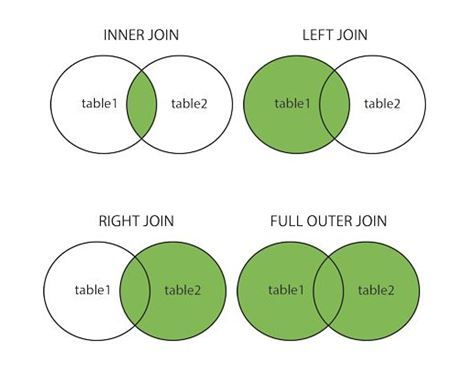

* left_set = {1,2,3,4,5}
* right_set = {4,5,6,7,8}

* inner_join = {4,5}
* left_join = {1,2,3,4,5}
* right_join = {4,5,6,7,8}
* full_outer_join = {1,2,3,4,5,6,7,8}

In [ ]:
df_pgen1.head()

In [ ]:
df_psense1.head()

In [ ]:
## join the two dataframes - df_pgen1 and df_psense1

result_left = pd.merge(df_pgen1,df_psense1, on='DATE_TIME',how='left') #left, right, outer, inner

In [ ]:
result_right = pd.merge(df_pgen1,df_psense1, on='DATE_TIME',how='right') #left, right, outer, inner

In [ ]:
result_inner = pd.merge(df_pgen1,df_psense1, on='DATE_TIME',how='inner') #left, right, outer, inner

In [ ]:
result_inner.shape

In [ ]:
result_left['AMBIENT_TEMPERATURE'].isnull().value_counts()

In [ ]:
result_left['DC_POWER'].isnull().value_counts()

In [ ]:
result_left.shape

In [ ]:
df_pgen1.shape

In [ ]:
df_psense1.shape

In [ ]:
3182*22

In [ ]:
result_left.head()

In [ ]:
result_right.head()

In [ ]:
result_right.shape

In [ ]:
result_right['DC_POWER'].isnull().value_counts()

In [ ]:
result_inner['DC_POWER'].isnull().value_counts()

In [ ]:
result_inner['AMBIENT_TEMPERATURE'].isnull().value_counts()

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(result_left.IRRADIATION,
        result_left.DC_POWER,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='DC POWER')

ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('DC Power vs. Irradiation')
plt.xlabel('Irradiation')
plt.ylabel('DC Power')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

ax.plot(result_left.MODULE_TEMPERATURE,
        result_left.DC_POWER,
        marker='o',
        linestyle='',
        alpha=.5,
        ms=10,
        label='DC POWER')

ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('DC Power vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('DC Power')
plt.show()

In [ ]:
dates = result_left['DATE_x'].unique()

_, ax = plt.subplots(1, 1, figsize=(18, 9))


for date in dates:
    data = result_left[(result_left['DATE_x']==date)&(result_left['IRRADIATION']>0)]

    ax.plot(data.MODULE_TEMPERATURE,
            data.DC_POWER,
            marker='o',
            linestyle='',
            alpha=.5,
            ms=10,
            label=pd.to_datetime(date,format='%Y-%m-%d').date()
           )
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('DC Power vs. Module Tempreture')
plt.xlabel('Module Tempreture')
plt.ylabel('DC Power')
plt.show()

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(18, 9))

date = dates[4]
inverters = result_left['SOURCE_KEY_x'].unique()

for inverter in inverters:

    data = result_left[(result_left['DATE_x']==date)&(result_left['SOURCE_KEY_x']==inverter)&(result_left['IRRADIATION']>0.1)]

    ax.plot(data.MODULE_TEMPERATURE,
                data.DC_POWER,
                marker='o',
                linestyle='',
                alpha=.5,
                ms=10,
                label=inverter
               )
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('DC Power vs. Module Temperature')
plt.xlabel('Module Temperature')
plt.ylabel('DC Power')
plt.show()

What we covered today? (August 25th)

1. How to integrate data or merge dataframes
2. Different types of joins/merges
3. Answer questions that needed data across the dataframes
4. How to tell a story - problem, possible solution, characters, setting, plot

What will we do today?

1. Introduction to machine learning
2. Start using ScikitLearn for linear regression - univariate and multivariate

In [ ]:
result_left['IRRADIATION'] = result_left['IRRADIATION'].fillna(0)
result_left['AMBIENT_TEMPERATURE'] = result_left['AMBIENT_TEMPERATURE'].fillna(0)
result_left['MODULE_TEMPERATURE'] = result_left['MODULE_TEMPERATURE'].fillna(0)

X = result_left.iloc[:, 15:16].values #Irradiation
y = result_left.iloc[:, 3].values #DC_Power

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

In [ ]:
# Let's predict!
y_pred = lin_reg.predict(X_test)

In [ ]:
lin_reg.coef_

In [ ]:
# Lets look at our prediction curve vs. our data

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [ ]:
# How close or far are we? Lets Compare.

compare_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
compare_df.head(10)

In [ ]:
from sklearn import metrics
import numpy as np

print("Train Set Accuracy")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, lin_reg.predict(X_train)))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, lin_reg.predict(X_train)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, lin_reg.predict(X_train))))
print('---------------------------')
print("Test Set Accuracy")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1. Overfitted
2. Underfitted

In [ ]:
result_left['DC_POWER'].mean()

In [ ]:
600/3147*100

### Let's start again. This time with two variables!

In [ ]:
X = result_left[['IRRADIATION','MODULE_TEMPERATURE']]
y = result_left['DC_POWER']

In [ ]:
# Test-train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Fitting the model

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

In [ ]:
coeff_df = pd.DataFrame(lin_reg.coef_,X.columns,columns = ['Coefficients'])
coeff_df

In [ ]:
# Predict!

y_pred = lin_reg.predict(X_test)

In [ ]:
# Compare

compare_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
compare_df.head(10)

In [ ]:
# Validate

print("Train Set Accuracy")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, lin_reg.predict(X_train)))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, lin_reg.predict(X_train)))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, lin_reg.predict(X_train))))
print('---------------------------')
print("Test Set Accuracy")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# How would you predict one value?

lin_reg.predict([[0.4,50]]) #0.4 irradiation and 50 degrees of module temperature

----
## Time Series Analysis

### Predict the value of irradiation

Trends for change in irradiation - 
1. Time of the day
2. Month of the year, season

In [ ]:
## Create a day-wise summary - 

day_summary = df_psense1.groupby('DATE').agg(TOTAL_IRRADIANCE = ('IRRADIATION', sum),
                                         DATE = ('DATE',max)
                                        )

In [ ]:
day_summary

In [ ]:
import fbprophet

In [ ]:
# Prophet requires columns ds (Date) and y (value)
day_summary = day_summary.rename(columns={'DATE': 'ds', 'TOTAL_IRRADIANCE': 'y'})

In [ ]:
day_summary

In [ ]:
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.25) # the parameter defines how tightly you want to fit your model

gm_prophet.fit(day_summary)

In [ ]:
# Make a future dataframe for 1 month
gm_forecast = gm_prophet.make_future_dataframe(periods=90, freq='D')

# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

In [ ]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Irradiation')
plt.title('Irradiation Prediction')

In [ ]:
sense1_renamed = df_psense1.rename(columns={'DATE_TIME':'ds', 'IRRADIATION':'y'})

In [ ]:
sense1_renamed

In [ ]:
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.25) # the parameter defines how tightly you want to fit your model

gm_prophet.fit(sense1_renamed)

In [ ]:
# Make a future dataframe for 4 days
gm_forecast = gm_prophet.make_future_dataframe(periods=96, freq='H')

# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

In [ ]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Irradiation')
plt.title('Irradiation Prediction')

In [ ]:
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.5) # the parameter defines how tightly you want to fit your model

gm_prophet.fit(sense1_renamed)

In [ ]:
# Make a future dataframe for 4 days
gm_forecast = gm_prophet.make_future_dataframe(periods=96, freq='H')

# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Irradiation')
plt.title('Irradiation Prediction')